# Mixtures of PPCA's
In this chapter, we introduce mixtures of PPCA models.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
sns.set()

In [2]:
moppcas_code = """

data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  int<lower=2> D;          // number of observed variables
  int<lower=1> M;          // number of latent dimensions
  matrix[N,D] y;           // observations
}

parameters {
  simplex[K] theta;          // mixing proportions
  vector[D] mu[K];            // locations of mixture components
  real<lower=0,upper=10> sigma[K];  // scales of mixture components
  matrix[M,N] z[K];  // latent data
  matrix[D,M] W[K];  // factor loadings
  
}

transformed parameters{
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model {
    vector[K] log_theta = log(theta);  // cache log calculation
    
    
    for (k in 1:K){
        //if (theta[k]<0.05){
            //target+= -100000;
        //}
        for (n in 1:N){
            z[k][:,n] ~ multi_normal(mean_z, cov_z);
        }
    }    

    
    for (n in 1:N){
    vector[K] lps = log_theta;
        for (k in 1:K){
            for (d in 1:D){
                lps[k] += normal_lpdf(y[n,d] | W[k][d,:]*col(z[k],n)+mu[k][d], sigma[k]);
                }
            }
        target += log_sum_exp(lps);
        }
}

generated quantities{
    matrix[N,K] clusters;
    
    
    for (n in 1:N){
        for (k in 1:K){
            clusters[n,k] = log(theta[k]);
            for (d in 1:D){
                clusters[n,k] += normal_lpdf(y[n,d] | W[k][d,:]*col(z[k],n)+mu[k][d], sigma[k]);
                
            }
        }
    }
    
}


"""
moppcas_model = pystan.StanModel(model_code=moppcas_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0583dd605370801c94ad0bd7e9448afe NOW.


In [3]:
N=1000
M=2
D=3
K=3
mu = np.random.uniform(-50,50,size=(K,D))
sigma = np.random.uniform(0,5,size=(K))
theta = np.random.dirichlet(np.ones(K))

z = []
W = []
for k in range(K):
    W.append(np.random.normal(0,1.0,size=(D,M)))
    z.append(np.random.normal(0,1, size=(M,N)))
    
x = np.zeros((N,D))
ind = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    x[n,:] = np.random.normal(np.matmul(W[opt],z[opt][:,n])+mu[opt], sigma[opt])
    ind.append(opt)
x
print('theta: ', theta)
print()
for k in range(K):
    print('W_'+str(k)+':\n',W[k])
    print('mu_'+str(k)+': ',mu[k,:])
    print('sigma_'+str(k)+': ',sigma[k])
    print()

theta:  [0.67550579 0.08585799 0.23863622]

W_0:
 [[-0.72053338  0.89333721]
 [-2.08934088 -0.87959089]
 [-0.59585801 -0.53998965]]
mu_0:  [-49.31505956 -17.16348586 -39.06069295]
sigma_0:  3.5916318657264994

W_1:
 [[ 1.44017721 -0.53426489]
 [-0.60969444  1.54140908]
 [-0.53442028  0.03801355]]
mu_1:  [-38.85380544  -7.37809552  23.91668153]
sigma_1:  1.8402186805092873

W_2:
 [[ 1.41174933 -1.67620163]
 [ 0.72757931  1.25885212]
 [ 1.1655185  -1.08844069]]
mu_2:  [ 25.96730325  -9.68258399 -17.80800669]
sigma_2:  1.4459297187744746



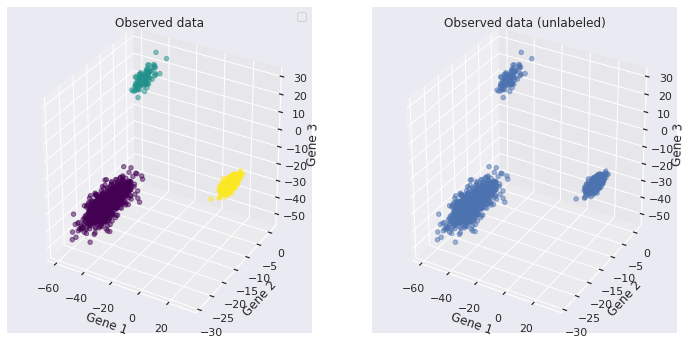

In [4]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis', alpha=0.5)
ax.set_title('Observed data (unlabeled)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

In [5]:
gmm_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
theta_sim = np.mean(fit_ext['theta'],axis=0)
mu_sim = np.mean(fit_ext['mu'],axis=0)
sigmas_sim = np.mean(fit_ext['sigma'],axis=0)
z_sim = fit_ext['z'][best_ind]
W_sim = np.mean(fit_ext['W'],axis=0)
clusters = np.mean(fit_ext['clusters'],axis=0)

order = True         # this tries to set the simulated clusters in the same order as the original; good for testing costly for real use
if order:
    mu_diffs = np.ones((K,K))
    for i in range(K):
        for j in range(K):
            mu_diffs[i,j] = sum([(mu[i][d]-mu_sim[j][d])**2 for d in range(D)])

    best_score = 10000
    for perm in list(itertools.permutations(list(range(K)))):
        score = 0
        for i,j in enumerate(perm):
            score+=mu_diffs[i,j]
        if score<best_score:
            best_order = perm
            best_score = score
    
    theta_sim = np.array([theta_sim[i] for i in best_order])
    mu_sim = np.array([mu_sim[i] for i in best_order])
    sigmas_sim = np.array([sigmas_sim[i] for i in best_order])
    z_sim = [z_sim[i] for i in best_order]
    W_sim = np.array([W_sim[i] for i in best_order])


print('Real theta: ',theta)
print('Sample theta: ',[sum(np.array(ind)==k)/N for k in range(K)])
print('Simulated theta: ',theta_sim)
print()
print('actual mu:\n',mu)
print('Simulated mu:\n',mu_sim)
print()
print('actual sigmas: ',sigma)
print('Simulated sigmas: ',sigmas_sim)
print()
for k in range(K):
    print('Actual WW^T_'+str(k)+': ')
    print(np.matmul(W[k],W[k].T))
    print('Simulated WW^T_'+str(k)+': ')
    print(np.matmul(W_sim[k],W_sim[k].T))
    print()

Real theta:  [0.67550579 0.08585799 0.23863622]
Sample theta:  [0.666, 0.083, 0.251]
Simulated theta:  [0.66070261 0.08370448 0.25559292]

actual mu:
 [[-49.31505956 -17.16348586 -39.06069295]
 [-38.85380544  -7.37809552  23.91668153]
 [ 25.96730325  -9.68258399 -17.80800669]]
Simulated mu:
 [[-49.37874699 -16.90769743 -39.11473751]
 [-39.15818961  -7.29674682  23.63288389]
 [ 25.94169394  -9.74399391 -17.73552399]]

actual sigmas:  [3.59163187 1.84021868 1.44592972]
Simulated sigmas:  [3.62129006 2.02896898 1.50644177]

Actual WW^T_0: 
[[ 1.31721972  0.71966858 -0.05305726]
 [ 0.71966858  5.13902546  1.71992047]
 [-0.05305726  1.71992047  0.64663559]]
Simulated WW^T_0: 
[[0.17114118 0.80145463 0.33200507]
 [0.80145463 4.2852622  1.80542171]
 [0.33200507 1.80542171 0.76214655]]

Actual WW^T_1: 
[[ 2.35954938 -1.70158881 -0.78996922]
 [-1.70158881  2.74766928  0.38442751]
 [-0.78996922  0.38442751  0.28705007]]
Simulated WW^T_1: 
[[ 1.11477551 -1.39039126 -0.17159391]
 [-1.39039126  2.1

In [7]:
# debug check for mixture cmponents analysis
# clusters = np.zeros((N,K))
# for n in range (N):
#     for k in range(K):
#         clusters[n,k] += np.log(theta_sim[k])
#         for d in range(D):
#             clusters[n,k] += norm.logpdf(x[n,d], np.matmul(W_sim[k][d,:],z_sim[k][:,n])+mu_sim[k][d], sigmas_sim[k])

In [8]:
clusters = (np.exp(clusters).T/sum(np.exp(clusters).T)).T                

In [9]:
z_cats = []
for n in range(N):
    for k in range(K):
        if clusters[n,k] == max(clusters[n,:]):
            z_cats.append(k)
            break

In [10]:
x_rec = np.zeros((N,D))
ind_rec = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta_sim)
    x_rec[n,:] = np.random.normal(np.matmul(W_sim[opt],z_sim[opt][:,n])+mu_sim[opt], sigmas_sim[opt])
    ind_rec.append(opt)

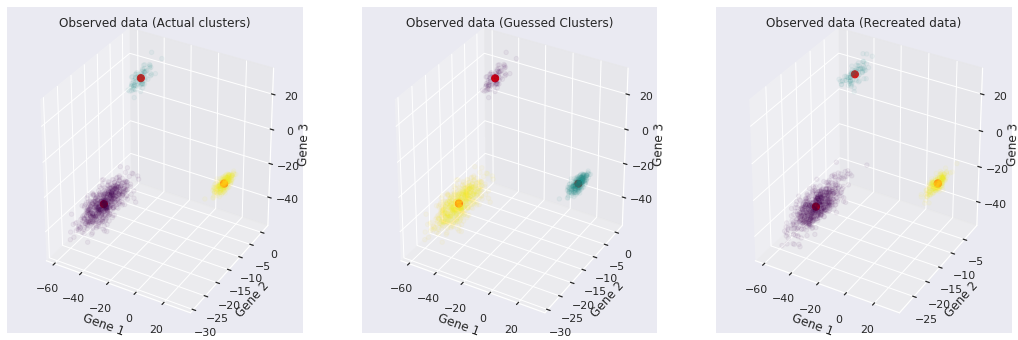

In [31]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=ind, cmap='viridis', alpha=0.05)
ax.scatter(mu[:,0],mu[:,1],mu[:,2], c='red', s=50, zorder=2, alpha=1)
ax.set_title('Observed data (Actual clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=z_cats, cmap='viridis', alpha=0.05,zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Guessed Clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_rec[:,0],x_rec[:,1],x_rec[:,2],c=ind_rec, cmap='viridis', alpha=0.05, zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Recreated data)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

The red dots in the above plot illustrate the real (left figure) and estimated (centre and right figure) values of $\mu$.

In [34]:
for k in range(K):
    print('Actual mean of latent cluster '+str(k), np.mean(z[k],axis=1))
    print('Actual std. dev of latent cluster '+str(k), np.std(z[k],axis=1))
    print('Estimated mean of latent cluster '+str(k), np.mean(z_sim[k],axis=1))
    print('Estimated std. dev of latent cluster '+str(k), np.std(z_sim[k],axis=1))
    print()

Actual mean of latent cluster 0 [-0.00260107  0.03161778]
Actual std. dev of latent cluster 0 [0.97390446 0.97748983]
Estimated mean of latent cluster 0 [0.04020156 0.00162174]
Estimated std. dev of latent cluster 0 [0.98687221 1.01461547]

Actual mean of latent cluster 1 [-0.04836542 -0.01401462]
Actual std. dev of latent cluster 1 [0.98581456 0.99978927]
Estimated mean of latent cluster 1 [-0.00261653  0.01743279]
Estimated std. dev of latent cluster 1 [0.95454779 0.97393547]

Actual mean of latent cluster 2 [ 0.00391753 -0.04665694]
Actual std. dev of latent cluster 2 [0.99522015 0.99025046]
Estimated mean of latent cluster 2 [ 0.00214202 -0.06637699]
Estimated std. dev of latent cluster 2 [0.97691627 1.01161595]



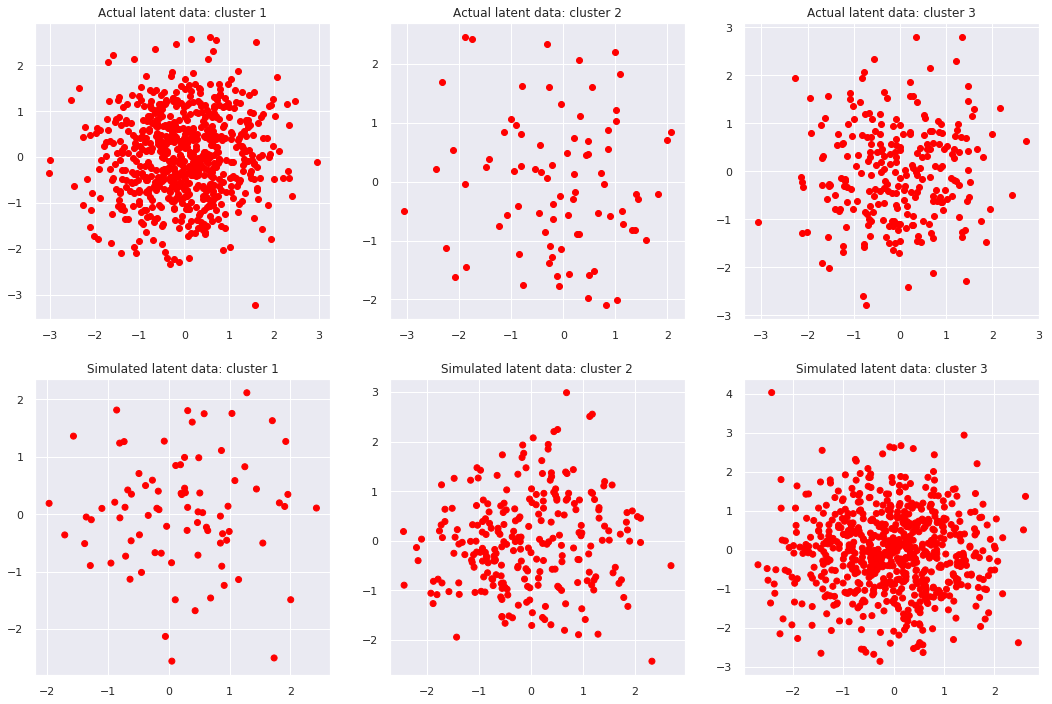

In [33]:
sns.set()
vis_threshold = 0.01

fig = plt.figure(figsize=(6*K,12))
for k in range(K):
    ax = fig.add_subplot(2,K,k+1)
    ax.scatter(z[k][0,np.array(ind)==k],z[k][1,np.array(ind)==k], c='red')
    ax.set_title('Actual latent data: cluster '+str(k+1))
    
for k in range(K):
    ax = fig.add_subplot(2,K,K+k+1)
    plotz = z_sim[k][:,clusters[:,k]>vis_threshold]
    rgba_colors = np.zeros((sum(clusters[:,k]>vis_threshold),4))
    rgba_colors[:,0] = 1.0
    rgba_colors[:, 3] = clusters[:,k][clusters[:,k]>vis_threshold]
    ax.scatter(plotz[0,:],plotz[1,:], c=rgba_colors)
    ax.set_title('Simulated latent data: cluster '+str(k+1))
    
plt.show()

Some clusters can be identified and separated, but sometimes the model clusters the latent data, in spite of its defined underlying distribution.